In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [176]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [177]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [178]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [179]:
X_train_re = get_encoded_sentences(get_decoded_sentences(X_train, index_to_word), word_to_index)
X_test_re = get_encoded_sentences(get_decoded_sentences(X_test, index_to_word), word_to_index)
print(len(X_train_re))
print(len(X_train))

146182
146182


In [180]:
print(len(X_test_re))
print(len(X_test))

49157
49157


In [181]:
X_train_re[0]

[1, 74, 919, 4, 4, 39, 228, 20, 33, 748]

In [182]:
total_data_text = list(X_train_re) + list(X_test_re)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843504626566713
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [183]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train_re,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test_re,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [193]:
from sklearn.model_selection import train_test_split
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train, 
                                                                  y_train, 
                                                                  test_size=0.1, 
                                                                  random_state=42)
print(partial_X_train.shape)
print(partial_y_train.shape)

(131563, 41)
(131563,)


In [41]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 41  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 41)          410000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 8)                 1600      
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 411,681
Trainable params: 411,681
Non-trainable params: 0
_________________________________________________________________


In [42]:
len(X_train)

146182

(116945, 41)
(116945,)


In [45]:
# # validation set 10000건 분리
# X_val = X_train[:10000]   
# y_val = y_train[:10000]

# # validation set을 제외한 나머지 15000건
#  = X_train[10000:]  
# partial_y_train = y_train[10000:]

# print(partial_X_train.shape)
# print(partial_y_train.shape)

In [46]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
457/457 [==============================] - 5s 11ms/step - loss: 0.4662 - accuracy: 0.7892 - val_loss: 0.3843 - val_accuracy: 0.8287
Epoch 2/8
457/457 [==============================] - 5s 10ms/step - loss: 0.3558 - accuracy: 0.8454 - val_loss: 0.3747 - val_accuracy: 0.8336
Epoch 3/8
457/457 [==============================] - 5s 10ms/step - loss: 0.3294 - accuracy: 0.8579 - val_loss: 0.3748 - val_accuracy: 0.8335
Epoch 4/8
457/457 [==============================] - 5s 10ms/step - loss: 0.3097 - accuracy: 0.8670 - val_loss: 0.3837 - val_accuracy: 0.8319
Epoch 5/8
457/457 [==============================] - 5s 10ms/step - loss: 0.2925 - accuracy: 0.8758 - val_loss: 0.3909 - val_accuracy: 0.8311
Epoch 6/8
457/457 [==============================] - 5s 10ms/step - loss: 0.2755 - accuracy: 0.8832 - val_loss: 0.3891 - val_accuracy: 0.8327
Epoch 7/8
457/457 [==============================] - 5s 10ms/step - loss: 0.2586 - accuracy: 0.8906 - val_loss: 0.3966 - val_accuracy: 0.8322
Epoch 

In [47]:
history_dict = history.history

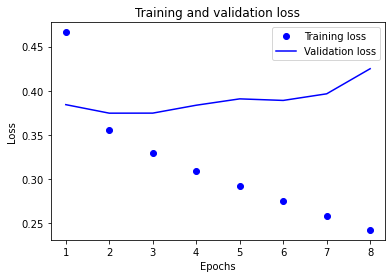

In [48]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

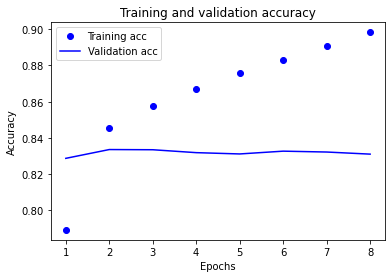

In [49]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**명사, 동사만으로 임베딩**
=====

In [124]:
from konlpy.tag import Okt  
tokenizer = Okt()

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        tokenlist = tokenizer.pos(sentence, stem=True, norm=True) # 단어 토큰화
        temp_X = [word[0] for word in tokenlist if word[1] in ['Noun', 'Verb']] # 명사, 동사일 때만
        if len(temp_X) > 2:
            X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        tokenlist = tokenizer.pos(sentence, stem=True, norm=True) # 단어 토큰화
        temp_X = [word[0] for word in tokenlist if word[1] in ['Noun', 'Verb']] # 명사, 동사일 때만
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [125]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [126]:
X_train_re = get_encoded_sentences(get_decoded_sentences(X_train, index_to_word), word_to_index)
X_test_re = get_encoded_sentences(get_decoded_sentences(X_test, index_to_word), word_to_index)
print(len(X_train_re))
print(len(X_train))

146182
146182


In [127]:
print(len(X_test_re))
print(len(X_test))

49157
49157


In [128]:
X_train_re[0]

[1, 10, 455]

In [ ]:
X

In [129]:
total_data_text = list(X_train_re) + list(X_test_re)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  7.932655537296699
문장길이 최대 :  51
문장길이 표준편차 :  6.858799126431309
pad_sequences maxlen :  21
전체 문장의 0.9356861661009834%가 maxlen 설정값 이내에 포함됩니다. 


In [130]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train_re,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test_re,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 21)


In [136]:
len(index_to_word)

10000

In [149]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 21  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(7))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경가능)
model.add(keras.layers.Dense(7, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, None, 21)          210000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 7)                 812       
_________________________________________________________________
dense_26 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 8         
Total params: 210,876
Trainable params: 210,876
Non-trainable params: 0
_________________________________________________________________


In [150]:
from sklearn.model_selection import train_test_split
partial_X_train, X_val, partial_y_train, y_val = train_test_split(X_train, 
                                                                  y_train, 
                                                                  test_size=0.2, 
                                                                  random_state=42)
print(partial_X_train.shape)
print(partial_y_train.shape)

(116945, 21)
(116945,)


In [151]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
1828/1828 [==============================] - 8s 4ms/step - loss: 0.5206 - accuracy: 0.7254 - val_loss: 0.4859 - val_accuracy: 0.7456
Epoch 2/5
1828/1828 [==============================] - 8s 4ms/step - loss: 0.4580 - accuracy: 0.7696 - val_loss: 0.4842 - val_accuracy: 0.7526
Epoch 3/5
1828/1828 [==============================] - 8s 4ms/step - loss: 0.4340 - accuracy: 0.7809 - val_loss: 0.4939 - val_accuracy: 0.7518
Epoch 4/5
1828/1828 [==============================] - 8s 4ms/step - loss: 0.4114 - accuracy: 0.7927 - val_loss: 0.5063 - val_accuracy: 0.7491
Epoch 5/5
1828/1828 [==============================] - 8s 4ms/step - loss: 0.3922 - accuracy: 0.8013 - val_loss: 0.5366 - val_accuracy: 0.7479


## pre_Trained wordtovec

In [152]:
import os
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'

In [157]:
import gensim
word2vec = gensim.models.Word2Vec.load(word2vec_path)

In [158]:
result = word2vec.wv.most_similar("강아지")
print(result)

[('고양이', 0.7290452122688293), ('거위', 0.7185634970664978), ('토끼', 0.7056223154067993), ('멧돼지', 0.6950401067733765), ('엄마', 0.6934334635734558), ('난쟁이', 0.6806551814079285), ('한마리', 0.6770296096801758), ('아가씨', 0.675035297870636), ('아빠', 0.6729633808135986), ('목걸이', 0.6512460708618164)]


In [160]:
word2vec['강아지']

<ipython-input-160-f35f0d9c7b07>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word2vec['강아지']


array([ 0.28099054, -0.19049376,  0.31788886, -0.29404902, -0.6012117 ,
       -0.25619242,  0.0061479 ,  0.51780385,  0.3608627 , -0.27890292,
        0.3753059 ,  0.45682365,  0.25841945,  0.29509434,  0.31509322,
        0.53255475, -0.3150408 ,  0.28672394,  0.32292762, -0.11534653,
        0.24962434, -0.31804952,  0.02379435,  0.34782323, -0.5428502 ,
       -0.31428298,  0.81061304,  0.7245631 ,  0.04309795, -1.0204421 ,
        0.10398801,  0.2138965 ,  0.10057439, -0.03146021,  0.0894748 ,
       -0.40986905,  0.11873247,  0.2684793 , -0.6372648 ,  0.36586553,
       -0.15963972,  0.3209763 , -0.6995127 , -1.1059827 ,  0.37646636,
       -0.82615834,  0.12098166, -0.04935855, -0.5623957 ,  0.1068015 ,
        0.2640723 ,  0.6015352 ,  0.31571352, -0.37577182, -0.5941042 ,
        0.1046523 , -0.16794747,  0.36965755,  0.18888052, -0.18799411,
        0.13297085,  0.13900231, -0.25006363, -0.7406368 ,  0.1037019 ,
       -0.18334036, -0.17581826,  0.08528292, -0.07013045,  0.45

In [161]:
index_to_word[6]

'보다'

In [164]:
len(word2vec['강아지'])

<ipython-input-164-9ffe2e9fc237>:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  len(word2vec['강아지'])


200

In [184]:
print(word2vec)

Word2Vec(vocab=30185, size=200, alpha=0.025)


In [185]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

<ipython-input-185-6d61b84044fb>:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
<ipython-input-185-6d61b84044fb>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [186]:
embedding_matrix.shape

(10000, 200)

In [187]:
embedding_matrix[0]

array([0.6919345 , 0.57134775, 0.31237288, 0.7426576 , 0.05287418,
       0.96679832, 0.42635998, 0.20475729, 0.17214227, 0.04762395,
       0.40356643, 0.44039626, 0.62455871, 0.77021774, 0.59451686,
       0.21511836, 0.32319252, 0.02603431, 0.74782898, 0.27444316,
       0.27752865, 0.43297592, 0.43840735, 0.28666453, 0.91038768,
       0.53904968, 0.97734067, 0.17751571, 0.0609138 , 0.08120988,
       0.92771306, 0.30797403, 0.58246213, 0.79926534, 0.90106311,
       0.35856604, 0.69694072, 0.47595919, 0.59504099, 0.64929435,
       0.40104132, 0.58238914, 0.92752122, 0.74266944, 0.26060391,
       0.09466226, 0.36620375, 0.58259371, 0.13158209, 0.94037401,
       0.40056138, 0.15831942, 0.40641598, 0.82621786, 0.51428548,
       0.69432502, 0.10155569, 0.42704243, 0.48420026, 0.33541018,
       0.50645694, 0.2202423 , 0.02994023, 0.67236779, 0.68476107,
       0.95469541, 0.87105588, 0.25915533, 0.10479293, 0.97150323,
       0.15809929, 0.56154067, 0.22557936, 0.60253916, 0.24069

In [194]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.MaxPooling1D())
model.add(keras.layers.Conv1D(16, 8, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 34, 16)            25616     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 17, 16)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 10, 16)            2064      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_35 (Dense)             (None, 1)               

In [195]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs = 8  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
257/257 [==============================] - 14s 55ms/step - loss: 0.5683 - accuracy: 0.6908 - val_loss: 0.4707 - val_accuracy: 0.7771
Epoch 2/8
257/257 [==============================] - 14s 55ms/step - loss: 0.4217 - accuracy: 0.8062 - val_loss: 0.4078 - val_accuracy: 0.8155
Epoch 3/8
257/257 [==============================] - 14s 54ms/step - loss: 0.3632 - accuracy: 0.8388 - val_loss: 0.3895 - val_accuracy: 0.8238
Epoch 4/8
257/257 [==============================] - 14s 54ms/step - loss: 0.3303 - accuracy: 0.8561 - val_loss: 0.3821 - val_accuracy: 0.8305
Epoch 5/8
257/257 [==============================] - 14s 54ms/step - loss: 0.3060 - accuracy: 0.8681 - val_loss: 0.3844 - val_accuracy: 0.8283
Epoch 6/8
257/257 [==============================] - 14s 55ms/step - loss: 0.2836 - accuracy: 0.8791 - val_loss: 0.3898 - val_accuracy: 0.8299
Epoch 7/8
257/257 [==============================] - 13s 52ms/step - loss: 0.2634 - accuracy: 0.8902 - val_loss: 0.4056 - val_accuracy: 0.8290